In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
!eotdl version

EOTDL Version: 2025.06.27-2


In [3]:
from glob import glob
import geopandas as gpd
import random
import matplotlib.pyplot as plt
import rasterio as rio
import numpy as np
from rasterio.plot import show
from tqdm import tqdm
from matplotlib.colors import ListedColormap
import os

# Dataset

In this notebook we show how to prepare a datasets with SCANEO for multi-task learning (classification + segmentation).

First we labeled 100 Sentinel 2 images using SCANEO. The images are randomly extracted from the dataset developed in https://www.eotdl.com/pipelines/UnsupervisedLearning.

Learn more about SCANEO in the [official repository](https://github.com/earthpulse/scaneo).

The data folder contains the images and annotations, you can start SCANEO to visualize and edit them (although this step is not necessary). We will later lean how to train a model with the dataset and use it in SCANEO for assisted labelling!

In [4]:
path = 'data'

images = sorted(glob(os.path.join(path, '*_TOA.tif')))

len(images), images[:3]

(100,
 ['data/20220709_173334_SN16_14N_425740_5033509_TOA.tif',
  'data/20220722_195752_SN30_14N_689562_4941198_TOA.tif',
  'data/20220729_153022_SN27_18S_800063_8428114_TOA.tif'])

In [5]:
labels = sorted(glob('data/*.geojson'))

len(labels), labels[:3]

(95,
 ['data/20220709_173334_SN16_14N_425740_5033509_TOA.geojson',
  'data/20220722_195752_SN30_14N_689562_4941198_TOA.geojson',
  'data/20220729_153022_SN27_18S_800063_8428114_TOA.geojson'])

In [6]:
images = [i.replace('geojson', 'tif') for i in labels]

len(images), labels[:3]

(95,
 ['data/20220709_173334_SN16_14N_425740_5033509_TOA.geojson',
  'data/20220722_195752_SN30_14N_689562_4941198_TOA.geojson',
  'data/20220729_153022_SN27_18S_800063_8428114_TOA.geojson'])

Labels coming from SCANEO are in GeoJSON format, and contain labels for the 3 tasks that we want to tackle in the use case: classification, semantic segmentation and object detection.

In [7]:
label = gpd.read_file(labels[1])

label

,label,task,geometry
0,vegetation,segmentation,"MULTIPOLYGON (((-96.61242 44.59585, -96.61242 ..."
1,vegetation,classification,POLYGON EMPTY


The full list of labels with associated colors can be found in the `spai.json` file

In [8]:
import json

with open('data/spai.json', 'r') as f:
    spai_labels = json.load(f)

spai_labels

{'labels': [{'name': 'bare soil', 'color': '#ffea00'},
  {'name': 'urban', 'color': '#ff0000'},
  {'name': 'vegetation', 'color': '#44ff00'},
  {'name': 'water', 'color': '#0033ff'}]}

In [9]:
colors = {label['name']: label['color'] for label in spai_labels['labels']}
colors

{'bare soil': '#ffea00',
 'urban': '#ff0000',
 'vegetation': '#44ff00',
 'water': '#0033ff'}

Let's visualize some samples

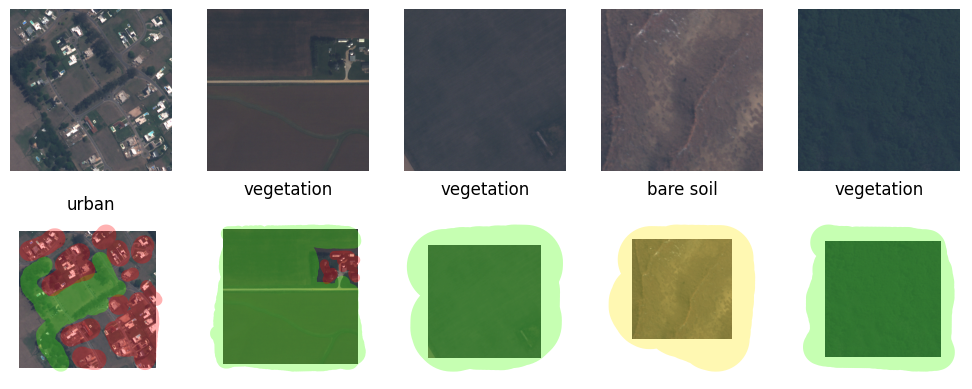

In [10]:
fig, axes = plt.subplots(2, 5, figsize=(10, 4))

for col in range(5):
    image = random.choice(images)
    ds = rio.open(image)
    img = np.clip(ds.read([1,2,3]) / 4000, 0, 1)
    axes[0, col].imshow(img.transpose(1,2,0))
    axes[0, col].axis('off')
    label = gpd.read_file(image.replace('tif', 'geojson')).to_crs(ds.crs)
    label['color'] = [colors[l] for l in label['label']]
    classification = label[label['task'] == 'classification']
    # axes[1, col].imshow(np.clip(img / 4000, 0, 1))
    show(img, transform=ds.transform, ax=axes[1, col])
    axes[1, col].axis('off')
    if len(classification) > 0:
        axes[1, col].set_title(', '.join(classification['label'].values))
    else:
        axes[1, col].set_title('NO CLS')
    segmentation = label[label['task'] == 'segmentation']
    if len(segmentation) > 0:
        segmentation.plot(color=segmentation['color'], linewidth=1, ax=axes[1, col], alpha=0.3)
    detection = label[label['task'] == 'detection']
    if len(detection) > 0:
        detection.plot(color=detection['color'], linewidth=1, ax=axes[1, col])


plt.tight_layout()
plt.show()


Classification and detection labels are ready to use, but for segmentation we may want to convert the polygons to masks.

















In [12]:
from eotdl.curation.scaneo import generate_masks_from_labels

generate_masks_from_labels('data')

  0%|          | 0/95 [00:00<?, ?it/s]

100%|██████████| 95/95 [00:00<00:00, 153.37it/s]


In [13]:
masks = sorted(glob('data/*_mask.tif'))
masks

['data/20220709_173334_SN16_14N_425740_5033509_TOA_mask.tif',
 'data/20220722_195752_SN30_14N_689562_4941198_TOA_mask.tif',
 'data/20220729_153022_SN27_18S_800063_8428114_TOA_mask.tif',
 'data/20220801_130037_SN18_23S_641151_7455522_TOA_mask.tif',
 'data/20220804_161527_SN24_19N_355852_4639129_TOA_mask.tif',
 'data/20220805_180510_SN31_20N_306037_5419893_TOA_mask.tif',
 'data/20220809_203408_SN31_13N_468227_3986894_TOA_mask.tif',
 'data/20220811_191729_SN27_11N_388341_3729255_TOA_mask.tif',
 'data/20220814_161320_SN29_22S_716497_8197245_TOA_mask.tif',
 'data/20220817_162738_SN15_16N_238010_4160131_TOA_mask.tif',
 'data/20220817_185942_SN22_19S_194239_8147033_TOA_mask.tif',
 'data/20220819_182623_SN16_11N_385787_3725906_TOA_mask.tif',
 'data/20220820_133634_SN11_21S_329575_6197590_TOA_mask.tif',
 'data/20220820_163059_SN9_15N_562170_1614428_TOA_mask.tif',
 'data/20220820_222702_SN20_11N_382331_3718994_TOA_mask.tif',
 'data/20220823_190626_SN16_10N_470796_5370637_TOA_mask.tif',
 'data/20

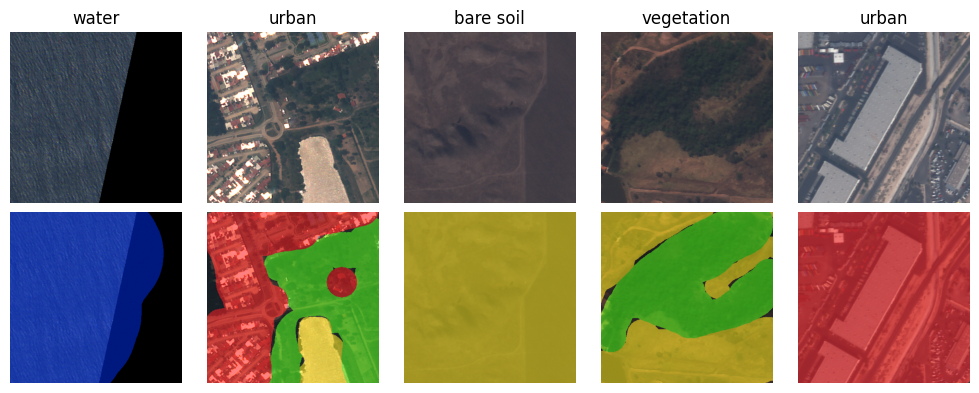

In [14]:
fig, axes = plt.subplots(2, 5, figsize=(10, 4))
_colors = ['#000000'] + [ colors.get(l) for l in list(colors.keys()) ]
cmap = ListedColormap(_colors)

for col in range(5):
    mask = random.choice(masks)
    image = mask.replace('_mask.tif', '.tif')
    ds = rio.open(image)
    img = np.clip(ds.read([1,2,3]) / 4000, 0, 1)
    axes[0, col].imshow(img.transpose(1,2,0))
    axes[0, col].axis('off')
    label = gpd.read_file(image.replace('tif', 'geojson')).to_crs(ds.crs)
    label['color'] = [colors[l] for l in label['label']]
    classification = label[label['task'] == 'classification']
    # axes[1, col].imshow(np.clip(img / 4000, 0, 1))
    show(img, transform=ds.transform, ax=axes[1, col])
    axes[1, col].axis('off')
    if len(classification) > 0:
        axes[0, col].set_title(', '.join(classification['label'].values))
    else:
        axes[0, col].set_title('NO CLS')
    detection = label[label['task'] == 'detection']
    if len(detection) > 0:
        detection.plot(color=detection['color'], linewidth=1, ax=axes[1, col])
    mask = rio.open(mask).read(1)
    # axes[1, col].imshow(mask, alpha=0.3)
    # show(mask, transform=ds.transform, ax=axes[1, col])
    show(mask, transform=ds.transform, ax=axes[1, col], cmap=cmap, vmin=0, vmax=len(colors)+1, alpha=0.5)


plt.tight_layout()
plt.show()

# EDA

Let's do some EDA on the dataset.

In [15]:
task_stats = {
    'cls_img': 0,
    'det_img': 0,
    'seg_img': 0,
    'cls_anns': 0,
    'det_anns': 0,
    'seg_anns': 0
}

for label in labels:
    label = gpd.read_file(label)
    classification = label[label['task'] == 'classification']
    detection = label[label['task'] == 'detection']
    segmentation = label[label['task'] == 'segmentation']
    if len(classification) > 0:
        task_stats['cls_img'] += 1
    if len(detection) > 0:
        task_stats['det_img'] += 1
    if len(segmentation) > 0:
        task_stats['seg_img'] += 1
    task_stats['cls_anns'] += len(classification)
    task_stats['det_anns'] += len(detection)
    task_stats['seg_anns'] += len(segmentation)

task_stats

{'cls_img': 95,
 'det_img': 0,
 'seg_img': 95,
 'cls_anns': 97,
 'det_anns': 0,
 'seg_anns': 128}

In [16]:
num_samples = {k: 0 for k in list(colors.keys())}
for label in labels:
    label = gpd.read_file(label)
    classification = label[label['task'] == 'classification']
    _labels = classification.label.values
    for label in _labels:
        num_samples[label] += 1

num_samples

{'bare soil': 13, 'urban': 19, 'vegetation': 42, 'water': 23}

In [17]:
num_samples = {k: 0 for k in list(colors.keys())}
for label in labels:
    label = gpd.read_file(label)
    segmentation = label[label['task'] == 'segmentation']
    _labels = segmentation.label.values
    for label in _labels:
        num_samples[label] += 1

num_samples

{'bare soil': 26, 'urban': 22, 'vegetation': 58, 'water': 22}